# 🦆 Dataset 전처리 [ML학습을 위한 전처리]

---
> sequence데이터로 학습하기에 ML 알고리즘으로는 어려움이 있다
>
> test데이터가 각각 특정한 유저가 푼 문제와 마지막 풀어야 할 문제로 구성되어 하나로 묶여있는 sequence데이터 형식이다
>
> 그대로 사용하면 예측해야 유저가 train에 아예 포함되지 않는 cold start 문제가 발생하여 데이터셋을 별도로 구성해야 한다

In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
# pd.set_option('display.max_rows', None)

# Data Load

---

In [2]:
origin_train_data_path = '/opt/ml/input/data/train_data.csv'
origin_test_data_path = '/opt/ml/input/data/test_data.csv'

train_data = pd.read_csv(origin_train_data_path)
test_data = pd.read_csv(origin_test_data_path)

# Create Dataset [Dataset Merge / Submission Dataset]

---

In [3]:
train_test_dataset = pd.concat([train_data, test_data], ignore_index=True)
train_test_dataset.drop_duplicates(subset=['userID', 'assessmentItemID', 'testId'], keep='last', inplace=True)
train_test_dataset = train_test_dataset.reset_index(drop=True)

# 대분류 카테고리 생성

---
> `assessmentItemID` ex_A080080003의 index=2 문자는 1-9 범위의 대분류이다

In [4]:
train_test_dataset['LargeCategory'] = train_test_dataset['assessmentItemID'].str[2]

# 정수화
train_test_dataset['LargeCategory'] = train_test_dataset['LargeCategory'].astype(int)

# Timestamp

---
```
## 미션-1 EDA 문제
diff = df.loc[:, ['userID', 'Timestamp']].groupby('userID').diff().fillna(pd.Timedelta(seconds=0))
diff = diff.fillna(pd.Timedelta(seconds=0))
diff = diff['Timestamp'].apply(lambda x: x.total_seconds())

df['elapsed'] = diff
```

> - 코드 문제점
>
>   1\. 결측치가 생기게 되는 첫 번째 값은 0으로 다 채워서 첫번째 문제는 푼 시간이 0이 나오는 문제 발생
> 
>   2\. groupby를 `userID`로만 하면서 다음 시험지까지 시간차가 있는 경우에도 그대로 diff() 함수가 적용되어 오차 발생
>
>   3\. 문제 푸는 시간은 다음 문제로 넘어가는 시간을 기준으로 해야하는 데 diff()만 사용하면 해당 줄 기준으로 앞줄 시간을 빼서 한 칸씩 밀린다<br>
> <br>
> - 해결 과정
>
>   1\. nan결측치로 방치 -> 추가로 전처리로 연결
>
>   2\. groupby를 `userID`, `testId`를 기반으로 적용하여 유저아이디를 기반으로 시험지 아이디로 추가적으로 분리
>
>   3\. .diff(periods=-1).abs()로 수정하여 앞에 값이 뒤에 값을 빼고 절대값으로 변경한다<br>
> <br>

In [5]:
train_test_dataset['Timestamp'] = pd.to_datetime(train_test_dataset['Timestamp'])
time_diff = train_test_dataset.loc[:, ['userID','testId', 'Timestamp']].groupby(['userID', 'testId']).diff(periods=-1).abs()
time_diff = time_diff['Timestamp'].apply(lambda x: x.total_seconds())
train_test_dataset['TimeElapsed'] = time_diff

# 시간 차이값 오류 해결

---
> - 문제 사항
>
>   같은 시험지와 같은 문제를 한번 더 풀 경우 첫번째 마지막으로 해결 했던 문제 시간이랑 연결이 되어 문제 풀이 시간이 커지는 경우가 발생
>
> - 해결 규칙
>
>   유저의 학습 상태는 최근에 풀었던 문제에 영향을 받는다. 이전에 맞추었더라도 최근에 틀렸다면 미레에 틀릴 것이고 최근에 맞추었다면 미래에도 맞을 확률이 높다
>
> - 고려해야 될 점
>
>   최근에 푼 문제를 기반으로 데이터를 전처리하므로 이전에 같은 문제를 풀었던 적이 있다면 생략된다
>
> - 해결 과정
>
>   `Create Dataset [Dataset Merge / Submission Dataset]` 셀에서 처음 데이터셋을 합칠 때 `train_test_dataset.drop_duplicates(subset=['userID', 'assessmentItemID', 'testId'], keep='last', inplace=True)`을 통해서 `['userID', 'assessmentItemID', 'testId']`가 중복될 경우 최신값을 기준으로 drop하도록 처리
>
> - 데이터 검증 과정
>
>   문제 마지막마다 생기는 TimeElapsed피쳐의 nan개수와 testId 종류의 개수 같으면 처리가 잘 된것으로 확인
>

In [6]:
print(f"""user_3099로 검증
user_3099의 TimeElapsed피쳐의 결측치 값 : {train_test_dataset[train_test_dataset['userID'] ==3099]['TimeElapsed'].isna().sum()}
user_3099의 testId 종류의 개수 : {len(train_test_dataset[train_test_dataset['userID'] ==3099]['testId'].unique())}
""")

user_3099로 검증
user_3099의 TimeElapsed피쳐의 결측치 값 : 108
user_3099의 testId 종류의 개수 : 108



# 시간 Outlier 처리

---

> - 주요 사항
>
>   outlier를 처리하기 위해 앞뒤 값을 잘라내는 경우가 있다
>   최소값은 0부터 시작하지만 문제를 찍는 다면 짧을 시간이 나올 수 있어, 유효한 값이다
>   하지만 최대값의 경우에는 문제를 푸는 것에 비해서 정상범위를 벗어난 값들이 있어 상위 값들은 모델의 학습에 방해가 될 만한 값들이였다
> 
> - 해결 방법
> 
>   0.05% 값들을 nan으로 처리하여 결측치로 변환하였다

## - scatter 그래프 [전처리전]

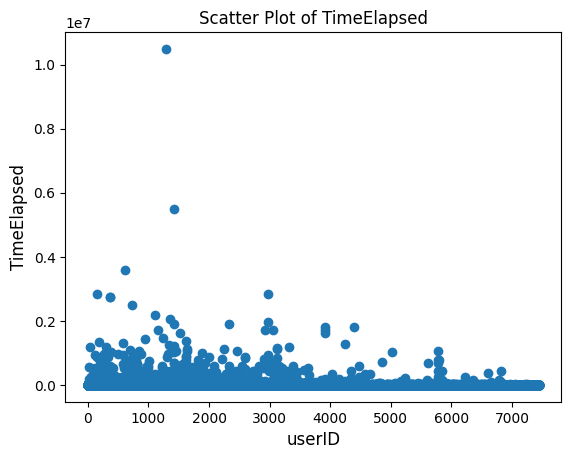

In [7]:
plt.scatter(x=train_test_dataset['userID'], y=train_test_dataset['TimeElapsed'])
plt.xlabel('userID', fontsize = 12)
plt.ylabel('TimeElapsed', fontsize = 12)
plt.title('Scatter Plot of TimeElapsed')
plt.show()

## - 0.5%의 상위 Outlier 제거

In [8]:
train_test_dataset[train_test_dataset['TimeElapsed'] >= train_test_dataset['TimeElapsed'].quantile(0.995)].sort_values('TimeElapsed', ascending=False)

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,LargeCategory,TimeElapsed
850675,1282,A080080003,A080000080,1,2020-07-25 17:50:47,26,8,10492440.0
927918,1418,A080082003,A080000082,1,2020-10-06 06:38:22,32,8,5508750.0
2271334,616,A070078002,A070000078,0,2020-08-07 20:13:03,9184,7,3588024.0
1634897,2981,A070009002,A070000009,1,2020-02-12 00:16:13,3820,7,2844518.0
115332,152,A090047003,A090000047,1,2020-09-16 10:06:16,2010,9,2834169.0
...,...,...,...,...,...,...,...,...
1415397,2418,A080097005,A080000097,1,2020-10-21 02:29:05,7171,8,1901.0
220888,306,A030108001,A030000108,0,2020-08-11 06:21:01,554,3,1901.0
2039686,4681,A060025002,A060000025,1,2020-07-16 02:55:15,595,6,1901.0
973649,1497,A040134002,A040000134,1,2020-07-05 09:50:25,10618,4,1901.0


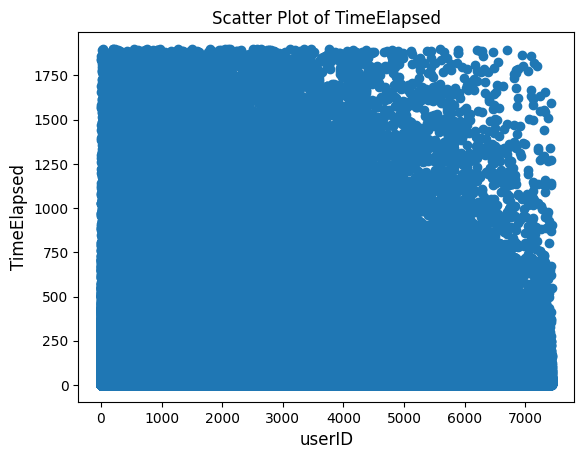

In [9]:
train_test_dataset.loc[train_test_dataset['TimeElapsed'] >= train_test_dataset['TimeElapsed'].quantile(0.995), 'TimeElapsed'] = float('nan')

plt.scatter(x=train_test_dataset['userID'], y=train_test_dataset['TimeElapsed'])
plt.xlabel('userID', fontsize = 12)
plt.ylabel('TimeElapsed', fontsize = 12)
plt.title('Scatter Plot of TimeElapsed')
plt.show()

# TimeElapsed 결측치 채우기

---

> `userID`,	`assessmentItemID`,	`testId`, `KnowledgeTag`, `LargeCategory`를 기준으로 각 피처당 `TimeElapsed` 평균 값으로 새 피처 생성
> 
> - 결측치 연산 제외 피처 [`LargeCategory`]
>
>   1-9 범위로 이루어져 있어 정밀화에 방해를 줄 수 있다

In [10]:
def _fill_nan_process(dataset: pd.DataFrame, columns_list: list) -> pd.DataFrame:
    for name in columns_list:
        create_column_name = name + '_time_average'
        time_average = dataset.groupby(name)['TimeElapsed'].mean()
        dataset[create_column_name] = train_test_dataset[name].map(time_average)
    return dataset

columns = ['userID', 'assessmentItemID', 'testId', 'KnowledgeTag', 'LargeCategory']
train_test_dataset = _fill_nan_process(train_test_dataset, columns)

## - 결측치 확인

In [11]:
train_test_dataset.isna().sum()

userID                                0
assessmentItemID                      0
testId                                0
answerCode                            0
Timestamp                             0
KnowledgeTag                          0
LargeCategory                         0
TimeElapsed                      417540
userID_time_average                   0
assessmentItemID_time_average      6227
testId_time_average                   0
KnowledgeTag_time_average             0
LargeCategory_time_average            0
dtype: int64

## - 결측치 처리

> 먼저 `ItemID_time_average`의 결측치를 치운 후 `ItemID_time_average`의 값을 함께 포함한 평균으로 `TimeElapsed`를 채운다

In [12]:
mean_values = train_test_dataset[['userID_time_average', 'testId_time_average', 'KnowledgeTag_time_average']].mean(axis=1)
train_test_dataset['assessmentItemID_time_average'].fillna(mean_values, inplace=True)

mean_values = train_test_dataset[['userID_time_average', 'assessmentItemID_time_average', 'testId_time_average', 'KnowledgeTag_time_average']].mean(axis=1)
train_test_dataset['TimeElapsed'].fillna(mean_values, inplace=True)

## - 결측치 처리 완료

In [13]:
train_test_dataset

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,LargeCategory,TimeElapsed,userID_time_average,assessmentItemID_time_average,testId_time_average,KnowledgeTag_time_average,LargeCategory_time_average
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,6,3.000000,40.818466,13.836735,22.675102,20.156676,72.634595
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,6,8.000000,40.818466,26.318367,22.675102,33.339925,72.634595
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,6,7.000000,40.818466,18.967347,22.675102,33.339925,72.634595
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,6,7.000000,40.818466,18.228571,22.675102,33.339925,72.634595
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,6,11.000000,40.818466,36.024490,22.675102,33.339925,72.634595
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2476701,7439,A040130001,A040000130,0,2020-10-14 23:07:23,8832,4,18.000000,40.846154,61.359589,61.569349,54.372304,68.434472
2476702,7439,A040130002,A040000130,1,2020-10-14 23:07:41,8832,4,21.000000,40.846154,44.811644,61.569349,54.372304,68.434472
2476703,7439,A040130003,A040000130,1,2020-10-14 23:08:02,8244,4,89.000000,40.846154,74.465517,61.569349,69.726821,68.434472
2476704,7439,A040130004,A040000130,1,2020-10-14 23:09:31,8244,4,32.000000,40.846154,66.044674,61.569349,69.726821,68.434472


In [14]:
# TimeElapsed 정수화
train_test_dataset['TimeElapsed'] = train_test_dataset['TimeElapsed'].astype(int)

# 계산이 끝난 columns 제거
train_test_dataset.drop(['userID_time_average', 'assessmentItemID_time_average', 'testId_time_average', 'KnowledgeTag_time_average', 'LargeCategory_time_average'], axis=1, inplace=True)

train_test_dataset

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,LargeCategory,TimeElapsed
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,6,3
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,6,8
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,6,7
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,6,7
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,6,11
...,...,...,...,...,...,...,...,...
2476701,7439,A040130001,A040000130,0,2020-10-14 23:07:23,8832,4,18
2476702,7439,A040130002,A040000130,1,2020-10-14 23:07:41,8832,4,21
2476703,7439,A040130003,A040000130,1,2020-10-14 23:08:02,8244,4,89
2476704,7439,A040130004,A040000130,1,2020-10-14 23:09:31,8244,4,32


In [15]:
train_test_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2476706 entries, 0 to 2476705
Data columns (total 8 columns):
 #   Column            Dtype         
---  ------            -----         
 0   userID            int64         
 1   assessmentItemID  object        
 2   testId            object        
 3   answerCode        int64         
 4   Timestamp         datetime64[ns]
 5   KnowledgeTag      int64         
 6   LargeCategory     int64         
 7   TimeElapsed       int64         
dtypes: datetime64[ns](1), int64(5), object(2)
memory usage: 151.2+ MB


In [16]:
train_test_dataset.isna().sum()

userID              0
assessmentItemID    0
testId              0
answerCode          0
Timestamp           0
KnowledgeTag        0
LargeCategory       0
TimeElapsed         0
dtype: int64

# combined_dataset / submission_dataset - 분리

---

> - combined_dataset : 전체 데이터 셋
>
>   ML학습을 위해서 시계열 데이터를 개별적으로 학습을 가능하게 하기 위해 변경  
>   학습 시에 별도로 train/test 나누는 단계가 필요
> 
> - submission_dataset : 제출을 위한 모델 인풋 데이터셋

In [17]:
combined_dataset = train_test_dataset[train_test_dataset['answerCode'] != -1].reset_index(drop=True)
submission_dataset = train_test_dataset[train_test_dataset['answerCode'] == -1].reset_index(drop=True)

In [18]:
combined_dataset

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,LargeCategory,TimeElapsed
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,6,3
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,6,8
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,6,7
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,6,7
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,6,11
...,...,...,...,...,...,...,...,...
2475957,7439,A040197006,A040000197,1,2020-08-21 07:39:45,2132,4,31
2475958,7439,A040130001,A040000130,0,2020-10-14 23:07:23,8832,4,18
2475959,7439,A040130002,A040000130,1,2020-10-14 23:07:41,8832,4,21
2475960,7439,A040130003,A040000130,1,2020-10-14 23:08:02,8244,4,89


In [19]:
submission_dataset

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,LargeCategory,TimeElapsed
0,3,A050133008,A050000133,-1,2020-10-26 13:13:57,5289,5,77
1,4,A070146008,A070000146,-1,2020-12-27 02:47:54,9080,7,71
2,13,A070111008,A070000111,-1,2020-12-27 04:35:09,9660,7,49
3,17,A090064006,A090000064,-1,2020-10-30 05:48:37,2611,9,59
4,26,A060135007,A060000135,-1,2020-10-23 11:44:18,1422,6,64
...,...,...,...,...,...,...,...,...
739,7395,A040122005,A040000122,-1,2020-09-08 02:05:20,10615,4,64
740,7404,A030111005,A030000111,-1,2020-10-13 09:49:18,7636,3,42
741,7416,A050193004,A050000193,-1,2020-10-04 02:44:41,10402,5,41
742,7417,A050193004,A050000193,-1,2020-09-06 13:09:15,10402,5,60


## - 각각의 columns 값에 따른 평균 answerCode_score

In [20]:
def _columns_to_averge_score(combined_dataframe: pd.DataFrame, submission_dataframe: pd.DataFrame,
                             columns_name: list) -> pd.DataFrame:
    for name in columns_name:
        create_column_name = name + '_average'
        average_data = combined_dataset.groupby(name)['answerCode'].mean()
        combined_dataframe[create_column_name] = combined_dataset[name].map(average_data)
        submission_dataframe[create_column_name] = combined_dataset[name].map(average_data)
    return combined_dataframe, submission_dataframe

columns = ['userID', 'assessmentItemID', 'testId', 'KnowledgeTag', 'LargeCategory', 'KnowledgeTag', 'TimeElapsed']
combined_dataset, submission_dataset = _columns_to_averge_score(combined_dataset, submission_dataset, columns)

# 전처리 완료

---

In [21]:
combined_dataset

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,LargeCategory,TimeElapsed,userID_average,assessmentItemID_average,testId_average,KnowledgeTag_average,LargeCategory_average,TimeElapsed_average
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,6,3,0.630872,0.983673,0.951701,0.957823,0.71120,0.258816
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,6,8,0.630872,0.967347,0.951701,0.916689,0.71120,0.642529
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,6,7,0.630872,0.914286,0.951701,0.916689,0.71120,0.579862
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,6,7,0.630872,0.971429,0.951701,0.916689,0.71120,0.579862
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,6,11,0.630872,0.946939,0.951701,0.916689,0.71120,0.741372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2475957,7439,A040197006,A040000197,1,2020-08-21 07:39:45,2132,4,31,0.733333,0.955782,0.773393,0.765596,0.68003,0.766132
2475958,7439,A040130001,A040000130,0,2020-10-14 23:07:23,8832,4,18,0.733333,0.440273,0.640710,0.639605,0.68003,0.781981
2475959,7439,A040130002,A040000130,1,2020-10-14 23:07:41,8832,4,21,0.733333,0.484642,0.640710,0.639605,0.68003,0.787128
2475960,7439,A040130003,A040000130,1,2020-10-14 23:08:02,8244,4,89,0.733333,0.846416,0.640710,0.764756,0.68003,0.670732


In [24]:
combined_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2475962 entries, 0 to 2475961
Data columns (total 14 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   userID                    int64         
 1   assessmentItemID          object        
 2   testId                    object        
 3   answerCode                int64         
 4   Timestamp                 datetime64[ns]
 5   KnowledgeTag              int64         
 6   LargeCategory             int64         
 7   TimeElapsed               int64         
 8   userID_average            float64       
 9   assessmentItemID_average  float64       
 10  testId_average            float64       
 11  KnowledgeTag_average      float64       
 12  LargeCategory_average     float64       
 13  TimeElapsed_average       float64       
dtypes: datetime64[ns](1), float64(6), int64(5), object(2)
memory usage: 264.5+ MB


In [22]:
submission_dataset

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,LargeCategory,TimeElapsed,userID_average,assessmentItemID_average,testId_average,KnowledgeTag_average,LargeCategory_average,TimeElapsed_average
0,3,A050133008,A050000133,-1,2020-10-26 13:13:57,5289,5,77,0.630872,0.983673,0.951701,0.957823,0.711200,0.258816
1,4,A070146008,A070000146,-1,2020-12-27 02:47:54,9080,7,71,0.630872,0.967347,0.951701,0.916689,0.711200,0.642529
2,13,A070111008,A070000111,-1,2020-12-27 04:35:09,9660,7,49,0.630872,0.914286,0.951701,0.916689,0.711200,0.579862
3,17,A090064006,A090000064,-1,2020-10-30 05:48:37,2611,9,59,0.630872,0.971429,0.951701,0.916689,0.711200,0.579862
4,26,A060135007,A060000135,-1,2020-10-23 11:44:18,1422,6,64,0.630872,0.946939,0.951701,0.916689,0.711200,0.741372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,7395,A040122005,A040000122,-1,2020-09-08 02:05:20,10615,4,64,0.630872,0.592784,0.356282,0.473548,0.500138,0.784293
740,7404,A030111005,A030000111,-1,2020-10-13 09:49:18,7636,3,42,0.630872,0.354005,0.356282,0.473548,0.500138,0.673618
741,7416,A050193004,A050000193,-1,2020-10-04 02:44:41,10402,5,41,0.630872,0.211340,0.356282,0.297611,0.500138,0.682407
742,7417,A050193004,A050000193,-1,2020-09-06 13:09:15,10402,5,60,0.630872,0.431525,0.356282,0.297611,0.500138,0.689582


In [25]:
submission_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 744 entries, 0 to 743
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   userID                    744 non-null    int64         
 1   assessmentItemID          744 non-null    object        
 2   testId                    744 non-null    object        
 3   answerCode                744 non-null    int64         
 4   Timestamp                 744 non-null    datetime64[ns]
 5   KnowledgeTag              744 non-null    int64         
 6   LargeCategory             744 non-null    int64         
 7   TimeElapsed               744 non-null    int64         
 8   userID_average            744 non-null    float64       
 9   assessmentItemID_average  744 non-null    float64       
 10  testId_average            744 non-null    float64       
 11  KnowledgeTag_average      744 non-null    float64       
 12  LargeCategory_average 

## - ML dataset csv save/load

In [23]:
# save csv
combined_dataset.to_csv('/opt/ml/project/DKT_data_BoostCamp/preprocess/ml_dataset/dataset.csv', index=False)
submission_dataset.to_csv('/opt/ml/project/DKT_data_BoostCamp/preprocess/ml_dataset/submission.csv', index=False)

In [59]:
# load csv
combined_dataset = pd.read_csv('/opt/ml/project/DKT_data_BoostCamp/preprocess/ml_dataset/dataset.csv')
submission_dataset = pd.read_csv('/opt/ml/project/DKT_data_BoostCamp/preprocess/ml_dataset/submission.csv')

In [27]:
combined_dataset

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,LargeCategory,TimeElapsed,userID_average,assessmentItemID_average,testId_average,KnowledgeTag_average,LargeCategory_average,TimeElapsed_average
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,6,3,0.630872,0.983673,0.951701,0.957823,0.71120,0.258816
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,6,8,0.630872,0.967347,0.951701,0.916689,0.71120,0.642529
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,6,7,0.630872,0.914286,0.951701,0.916689,0.71120,0.579862
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,6,7,0.630872,0.971429,0.951701,0.916689,0.71120,0.579862
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,6,11,0.630872,0.946939,0.951701,0.916689,0.71120,0.741372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2475957,7439,A040197006,A040000197,1,2020-08-21 07:39:45,2132,4,31,0.733333,0.955782,0.773393,0.765596,0.68003,0.766132
2475958,7439,A040130001,A040000130,0,2020-10-14 23:07:23,8832,4,18,0.733333,0.440273,0.640710,0.639605,0.68003,0.781981
2475959,7439,A040130002,A040000130,1,2020-10-14 23:07:41,8832,4,21,0.733333,0.484642,0.640710,0.639605,0.68003,0.787128
2475960,7439,A040130003,A040000130,1,2020-10-14 23:08:02,8244,4,89,0.733333,0.846416,0.640710,0.764756,0.68003,0.670732


In [28]:
submission_dataset

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,LargeCategory,TimeElapsed,userID_average,assessmentItemID_average,testId_average,KnowledgeTag_average,LargeCategory_average,TimeElapsed_average
0,3,A050133008,A050000133,-1,2020-10-26 13:13:57,5289,5,77,0.630872,0.983673,0.951701,0.957823,0.711200,0.258816
1,4,A070146008,A070000146,-1,2020-12-27 02:47:54,9080,7,71,0.630872,0.967347,0.951701,0.916689,0.711200,0.642529
2,13,A070111008,A070000111,-1,2020-12-27 04:35:09,9660,7,49,0.630872,0.914286,0.951701,0.916689,0.711200,0.579862
3,17,A090064006,A090000064,-1,2020-10-30 05:48:37,2611,9,59,0.630872,0.971429,0.951701,0.916689,0.711200,0.579862
4,26,A060135007,A060000135,-1,2020-10-23 11:44:18,1422,6,64,0.630872,0.946939,0.951701,0.916689,0.711200,0.741372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,7395,A040122005,A040000122,-1,2020-09-08 02:05:20,10615,4,64,0.630872,0.592784,0.356282,0.473548,0.500138,0.784293
740,7404,A030111005,A030000111,-1,2020-10-13 09:49:18,7636,3,42,0.630872,0.354005,0.356282,0.473548,0.500138,0.673618
741,7416,A050193004,A050000193,-1,2020-10-04 02:44:41,10402,5,41,0.630872,0.211340,0.356282,0.297611,0.500138,0.682407
742,7417,A050193004,A050000193,-1,2020-09-06 13:09:15,10402,5,60,0.630872,0.431525,0.356282,0.297611,0.500138,0.689582


## - Seqeunce 데이터 학습을 위한 dataset 변환

In [60]:
train_dataset = combined_dataset[~combined_dataset['userID'].isin(submission_dataset['userID'].unique())]
train_dataset

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,LargeCategory,TimeElapsed,userID_average,assessmentItemID_average,testId_average,KnowledgeTag_average,LargeCategory_average,TimeElapsed_average
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,6,3,0.630872,0.983673,0.951701,0.957823,0.711200,0.258816
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,6,8,0.630872,0.967347,0.951701,0.916689,0.711200,0.642529
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,6,7,0.630872,0.914286,0.951701,0.916689,0.711200,0.579862
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,6,7,0.630872,0.971429,0.951701,0.916689,0.711200,0.579862
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,6,11,0.630872,0.946939,0.951701,0.916689,0.711200,0.741372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2220628,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,3,52,0.555556,0.449324,0.666892,0.695475,0.702149,0.685778
2220629,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,4,11,0.555556,0.647260,0.651243,0.700148,0.680030,0.741372
2220630,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,4,46,0.555556,0.636986,0.651243,0.700148,0.680030,0.693468
2220631,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,4,73,0.555556,0.780822,0.651243,0.700148,0.680030,0.679417


In [61]:
test_dataset = pd.concat([submission_dataset, combined_dataset[combined_dataset['userID'].isin(submission_dataset['userID'])]], ignore_index=False)
test_dataset = test_dataset.sort_values(['userID','Timestamp', 'assessmentItemID']).reset_index(drop=True)
test_dataset

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,LargeCategory,TimeElapsed,userID_average,assessmentItemID_average,testId_average,KnowledgeTag_average,LargeCategory_average,TimeElapsed_average
0,3,A020027001,A020000027,1,2020-01-22 11:12:06,7912,2,91,0.695758,0.868687,0.731762,0.774460,0.738102,0.689582
1,3,A020027002,A020000027,1,2020-01-22 11:13:37,7912,2,64,0.695758,0.582492,0.731762,0.774460,0.738102,0.679543
2,3,A020027003,A020000027,1,2020-01-22 11:14:41,7912,2,17,0.695758,0.636364,0.731762,0.774460,0.738102,0.780453
3,3,A020027004,A020000027,1,2020-01-22 11:14:58,7912,2,14,0.695758,0.898990,0.731762,0.774460,0.738102,0.768297
4,3,A020027005,A020000027,1,2020-01-22 11:15:12,7912,2,65,0.695758,0.707071,0.731762,0.774460,0.738102,0.678775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256068,7439,A040130001,A040000130,0,2020-10-14 23:07:23,8832,4,18,0.733333,0.440273,0.640710,0.639605,0.680030,0.781981
256069,7439,A040130002,A040000130,1,2020-10-14 23:07:41,8832,4,21,0.733333,0.484642,0.640710,0.639605,0.680030,0.787128
256070,7439,A040130003,A040000130,1,2020-10-14 23:08:02,8244,4,89,0.733333,0.846416,0.640710,0.764756,0.680030,0.670732
256071,7439,A040130004,A040000130,1,2020-10-14 23:09:31,8244,4,32,0.733333,0.825939,0.640710,0.764756,0.680030,0.763752


## - Sequence dataset csv save/load

In [62]:
# save
train_dataset.to_csv('/opt/ml/project/DKT_data_BoostCamp/preprocess/sequence_dataset/train_dataset.csv', index=False)
test_dataset.to_csv('/opt/ml/project/DKT_data_BoostCamp/preprocess/sequence_dataset/test_dataset.csv', index=False)

In [64]:
# load csv
train_dataset = pd.read_csv('/opt/ml/project/DKT_data_BoostCamp/preprocess/sequence_dataset/train_dataset.csv')
test_dataset = pd.read_csv('/opt/ml/project/DKT_data_BoostCamp/preprocess/sequence_dataset/test_dataset.csv')

# 🦆 전처리 완료 🦆

```
ml_dataset/  
├── dataset.csv  
├── submission.csv  
└── sample_submission.csv
```


```
sequence_dataset/  
├── train_dataset.csv  
├── test_dataset.csv  
└── sample_submission.csv
```